In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation


In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


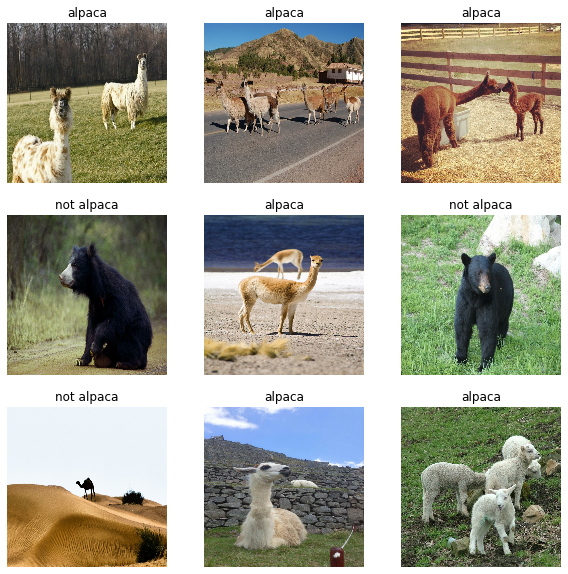

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    ### START CODE HERE
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2))
    ### END CODE HERE
    
    return data_augmentation

In [7]:
augmenter = data_augmenter()

assert(augmenter.layers[0].name.startswith('random_flip')), "First layer must be RandomFlip"
assert augmenter.layers[0].mode == 'horizontal', "RadomFlip parameter must be horizontal"
assert(augmenter.layers[1].name.startswith('random_rotation')), "Second layer must be RandomRotation"
assert augmenter.layers[1].factor == 0.2, "Rotation factor must be 0.2"
print('\033[92mAll tests passed!')


All tests passed!


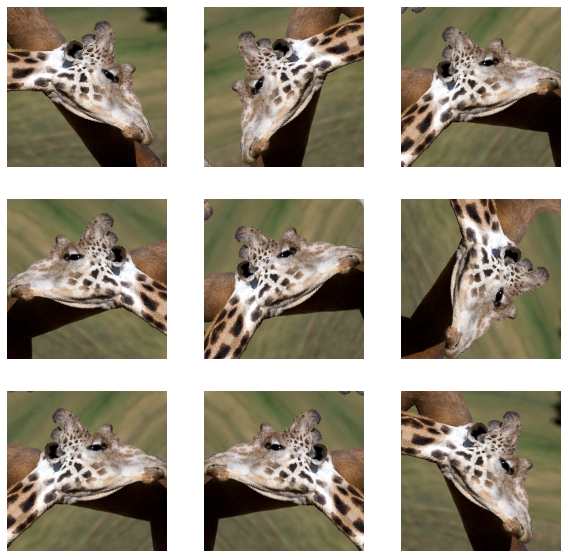

In [8]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights=r"C:\Users\Zain\Desktop\Course\Lec_11\dataset\mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5")

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [15]:
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

In [16]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n04589890', 'window_screen', 0.42582303),
  ('n02708093', 'analog_clock', 0.09275514)],
 [('n04589890', 'window_screen', 0.23985922),
  ('n03887697', 'paper_towel', 0.14802623)],
 [('n04589890', 'window_screen', 0.7449462),
  ('n03598930', 'jigsaw_puzzle', 0.021948516)],
 [('n04589890', 'window_screen', 0.33545983),
  ('n03530642', 'honeycomb', 0.07628953)],
 [('n04589890', 'window_screen', 0.2732742),
  ('n03733281', 'maze', 0.08846927)],
 [('n04589890', 'window_screen', 0.6745236),
  ('n03530642', 'honeycomb', 0.07659889)],
 [('n04589890', 'window_screen', 0.79128546),
  ('n04209239', 'shower_curtain', 0.09241615)],
 [('n04589890', 'window_screen', 0.16463025),
  ('n03598930', 'jigsaw_puzzle', 0.087491065)],
 [('n03598930', 'jigsaw_puzzle', 0.37021396),
  ('n04589890', 'window_screen', 0.09956949)],
 [('n04589890', 'window_screen', 0.6161646),
  ('n03887697', 'paper_towel', 0.054876737)],
 [('n03530642', 'honeycomb', 0.25448892),
  ('n04589890', 'window_screen', 0.24874333)],
 [(

In [17]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # Freeze the base model by making it non trainable
    base_model.trainable = False
    
    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    # Already Done -> preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # Add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    #include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # create a prediction layer with one neuron (as a classifier only needs one)
    prediction_layer = tfl.Dense(1)
    
    ### END CODE HERE
    
    outputs = prediction_layer(x) 
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [18]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [19]:
from test_utils import summary, comparator

alpaca_summary = [['InputLayer', [(None, 160, 160, 3)], 0],
                     ['Sequential', (None, 160, 160, 3), 0],
                     ['TFOpLambda', (None, 160, 160, 3), 0],
                     ['TFOpLambda', (None, 160, 160, 3), 0],
                     ['Functional', (None, 5, 5, 1280), 2257984],
                     ['GlobalAveragePooling2D', (None, 1280), 0],
                     ['Dropout', (None, 1280), 0, 0.2],
                     ['Dense', (None, 1), 1281, 'linear']] #linear is the default activation

comparator(summary(model2), alpaca_summary)

for layer in summary(model2):
    print(layer)

All tests passed!
['InputLayer', [(None, 160, 160, 3)], 0]
['Sequential', (None, 160, 160, 3), 0]
['TFOpLambda', (None, 160, 160, 3), 0]
['TFOpLambda', (None, 160, 160, 3), 0]
['Functional', (None, 5, 5, 1280), 2257984]
['GlobalAveragePooling2D', (None, 1280), 0]
['Dropout', (None, 1280), 0, 0.2]
['Dense', (None, 1), 1281, 'linear']


In [20]:
base_learning_rate = 0.01
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 19s 1s/step - loss: 0.5530 - accuracy: 0.7061 - val_loss: 0.1421 - val_accuracy: 0.9231
Epoch 2/5
9/9 [==============================] - 9s 879ms/step - loss: 0.2877 - accuracy: 0.8550 - val_loss: 0.1076 - val_accuracy: 0.9385
Epoch 3/5
9/9 [==============================] - 8s 815ms/step - loss: 0.2169 - accuracy: 0.9237 - val_loss: 0.1113 - val_accuracy: 0.9538
Epoch 4/5
9/9 [==============================] - 8s 810ms/step - loss: 0.1734 - accuracy: 0.9122 - val_loss: 0.0916 - val_accuracy: 0.9692
Epoch 5/5
9/9 [==============================] - 8s 863ms/step - loss: 0.2128 - accuracy: 0.8893 - val_loss: 0.0999 - val_accuracy: 0.9538


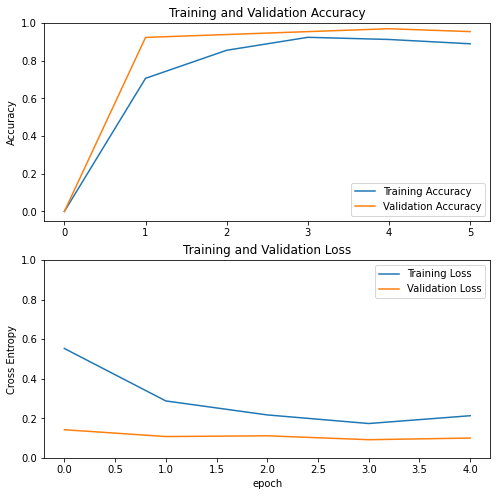

In [22]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
class_names

['alpaca', 'not alpaca']

In [24]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [25]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 126

### START CODE HERE

##### One Way ########
"""
for layer in base_model.layers:
    if layer.name == 'block_16_expand':
        break
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
"""
######## Other Way ######
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    #print('Layer ' + layer.name + ' frozen.')
    layer.trainable = None
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)# 0.001
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  156


In [26]:
assert type(loss_function) == tf.keras.losses.BinaryCrossentropy, "Not the correct layer"
assert loss_function.from_logits, "Use from_logits=True"
assert type(optimizer) == tf.keras.optimizers.Adam, "This is not an Adam optimizer"
assert optimizer.lr == base_learning_rate / 10, "Wrong learning rate"
assert metrics[0] == 'accuracy', "Wrong metric"

print('\033[92mAll tests passed!')


All tests passed!


In [27]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 15s 978ms/step - loss: 0.2051 - accuracy: 0.9198 - val_loss: 0.1145 - val_accuracy: 0.9385
Epoch 6/10
9/9 [==============================] - 8s 842ms/step - loss: 0.1368 - accuracy: 0.9427 - val_loss: 0.1105 - val_accuracy: 0.9385
Epoch 7/10
9/9 [==============================] - 8s 826ms/step - loss: 0.1343 - accuracy: 0.9275 - val_loss: 0.1014 - val_accuracy: 0.9538
Epoch 8/10
9/9 [==============================] - 8s 813ms/step - loss: 0.1082 - accuracy: 0.9656 - val_loss: 0.1131 - val_accuracy: 0.9385
Epoch 9/10
9/9 [==============================] - 9s 935ms/step - loss: 0.1453 - accuracy: 0.9504 - val_loss: 0.1153 - val_accuracy: 0.9385
Epoch 10/10
9/9 [==============================] - 9s 927ms/step - loss: 0.1647 - accuracy: 0.9389 - val_loss: 0.1091 - val_accuracy: 0.9385


In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

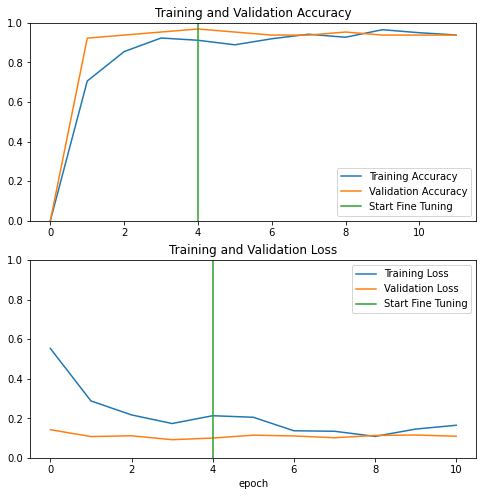

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()